In [1]:
import os 
import pickle

import jax
import jax.numpy as jnp
from jax import random
import blackjax
from numpyro.infer.util import initialize_model
import numpyro
from numpyro import handlers
from numpyro.infer import Predictive
import arviz as az
from numpyro.distributions import *
from numpyro.infer import SVI, Trace_ELBO, init_to_value
from numpyro.optim import Adam
import optax
import pandas as pd
import matplotlib.pyplot as plt
from fastprogress import progress_bar

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=16"

In [2]:
regions = pickle.load(open('test/luad34.regions.entropies.pkl', 'rb'))
df = regions[regions.chrom != 19]
data = jnp.array(regions[regions.chrom != 19].loc[:, 'log2_corrected'].values)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
def dirichlet_prior(states, target_state=jnp.array([2,2]), sigma=1.0):
    distances = jnp.linalg.norm(states - target_state, axis=1)
    return jnp.exp(-distances**2 / (2*sigma**2))


def model(data):

    weights = numpyro.sample("weights", Dirichlet(dirichlet_prior(states)))

    n = numpyro.sample("n", Beta(20.0, 2.0))
    
    s = numpyro.sample("s", Beta(2.0, 20.0))
    
    phi = numpyro.sample("phi", Gamma(10, 0.5))

    mu = numpyro.deterministic("mu", jnp.log((2 * n + (1 - n) * ((1 - s) * states[:, 0] + s * states[:, 1])) / (2 * n + (1 - n) * phi)))

    with numpyro.plate("states", n_states):
        scale = numpyro.sample("scale", HalfNormal(0.1))
        nu = numpyro.sample("nu", Gamma(3, 1))

    with numpyro.plate("data", len(data)):
        numpyro.sample("obs", MixtureSameFamily(Categorical(weights), StudentT(nu, mu, scale)), obs=data)

clonal = 6
states_set = {(c, c-1) for c in range(1, clonal)} | \
        {(c, c) for c in range(clonal)} | \
        {(c, c+1) for c in range(clonal)} | \
        {(c, 2) for c in range(clonal)}
states_df = pd.DataFrame(states_set, columns=['clonal', 'subclonal'])
states = jnp.array(states_df.values, dtype=jnp.float32)
n_states = len(states)

rng_key = jax.random.PRNGKey(0)
init_params, potential_fn_gen, *_ = initialize_model(
    rng_key,
    model,
    model_args=(data,),
    dynamic_args=True,
)

logdensity_fn = lambda position: -potential_fn_gen(data)(position)
initial_position = init_params.z
num_warmup = 100
adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn, target_acceptance_rate=0.8
)
(last_state, parameters), _ = adapt.run(rng_key, initial_position, num_warmup)
kernel = blackjax.nuts(logdensity_fn, **parameters).step


In [4]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )

num_sample = 1000

states, infos = inference_loop(rng_key, kernel, last_state, num_sample)


KeyError: 'mu'

In [10]:
# _ = states.position["mu"].block_until_ready()
import numpy as np
acceptance_rate = np.mean(infos[0])
num_divergent = np.mean(infos[1])

print(f"\Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

\Average acceptance rate: 0.84
There were 0.00% divergent transitions


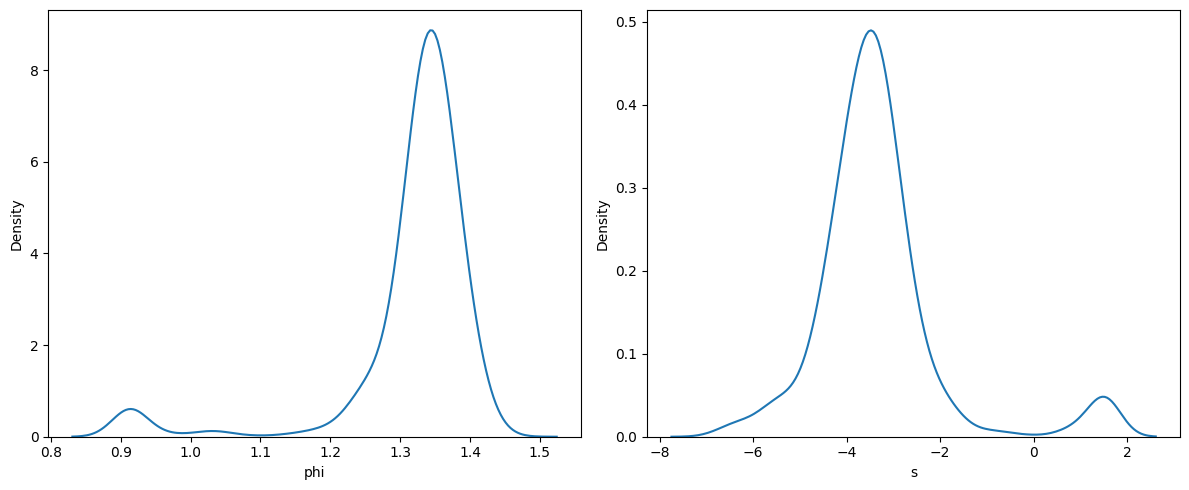

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt

samples = states.position

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.kdeplot(samples["phi"], ax=axes[0])
sns.kdeplot(samples["s"], ax=axes[1])
axes[0].set_xlabel("phi")
axes[1].set_xlabel("s")
fig.tight_layout()

In [ ]:
acceptance_rate = jnp.mean(infos[0])
num_divergent = jnp.mean(infos[1])

print(f"\Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

In [ ]:


# # from blackjax.sgmcmc.gradients import grad_estimator

# def batch_data(rng_key, data, batch_size, data_size):
#     """Return an iterator over batches of data."""
#     while True:
#         _, rng_key = jax.random.split(rng_key)
#         idx = jax.random.choice(
#             key=rng_key, a=jnp.arange(data_size), shape=(batch_size,)
#         )
#         yield data[idx]

# # rng_key = jax.random.PRNGKey(76)
# data_size = len(data)
# batch_size = 100
# batches = batch_data(rng_key, data, batch_size, data_size)
# # init_step_size = 1e-5
# # num_warmup = 1500
# # num_samples = 10000
# # sample_size = 100
# # schedule_fn = lambda _:  init_step_size
# # data_size = len(data)

# # position = {'sigma': 1.0,
# #             'weights': jnp.ones(n_states) / n_states,
# #             'n': 0.5,
# #             's': 0.5,
# #             'phi': 0.5,
# #             'nu': 0.5,
# #             'scale': 0.5}
# # # state = sgld.init(position)
# step_size = 1e-3
# minibatch = next(batches)
# # # step = jax.jit(sgld.step)
# sgld.step(rng_key, initial_position, minibatch, step_size)


100%|██████████| 3000/3000 [01:54<00:00, 26.21it/s, init loss: 375673.9688, avg. loss [2851-3000]: -329855.9062]


n: 0.9956190586090088
s: 0.4886525571346283
phi: 2.889413595199585


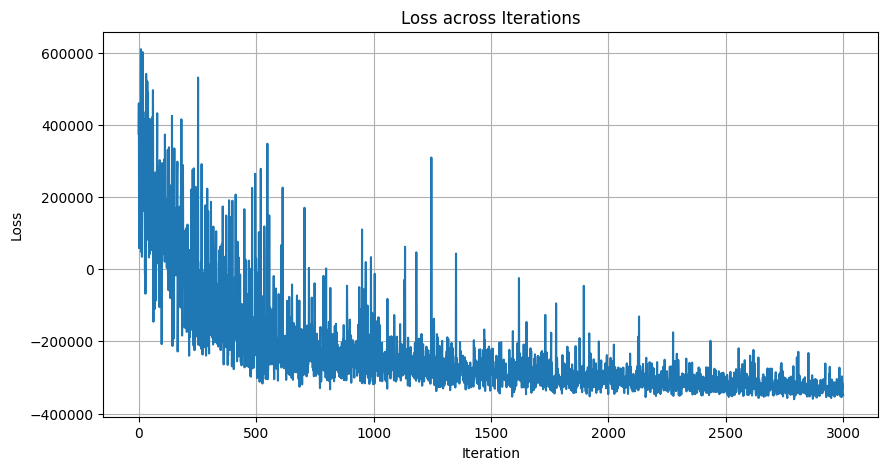

,clonal,subclonal,weights,scale,mu
15,4,2,0.218016,2.222942,-0.006105
11,4,4,0.191542,2.260430,-0.003498
4,4,3,0.131803,1.758664,-0.003240
18,3,3,0.088868,1.564898,0.001505
5,5,4,0.051106,1.113729,0.001731
17,4,5,0.044044,1.179459,0.004126
3,3,4,0.044023,1.252133,-0.004934
19,5,6,0.042879,1.147319,-0.002095
12,5,5,0.037425,1.125140,-0.005827
9,3,2,0.033531,0.937542,-0.000723


In [18]:
def train(num_iterations, data, optim):
    rng_key = random.PRNGKey(0)
    svi = SVI(model, guide, optim, loss=Trace_ELBO())
    return svi.run(rng_key, num_iterations, data, progress_bar=True)


def get_mu(c, cs, n, s, phi):
    return jnp.log((2 * n + (1 - n) * ((1 - s) * c + s * cs)) / (2 * n + (1 - n) * phi))


def dirichlet_prior(states, target_state=jnp.array([2,2]), sigma=1.0):
    distances = jnp.linalg.norm(states - target_state, axis=1)
    return jnp.exp(-distances**2 / (2*sigma**2))


def model(data):

    weights = numpyro.sample("weights", Dirichlet(dirichlet_prior(states)))

    n = numpyro.sample("n", Beta(20.0, 2.0))
    
    s = numpyro.sample("s", Beta(2.0, 20.0))
    
    phi = numpyro.sample("phi", Gamma(10, 0.5))

    mu = numpyro.deterministic("mu", jnp.log((2 * n + (1 - n) * ((1 - s) * states[:, 0] + s * states[:, 1])) / (2 * n + (1 - n) * phi)))

    with numpyro.plate("states", n_states):
        # nu = numpyro.sample("nu", Gamma(3, 1))
        scale = numpyro.sample("scale", HalfNormal(0.1))
    nu = 2.1
    with numpyro.plate("data", len(data), subsample_size=subsample_size) as ind:
        numpyro.sample("obs", MixtureSameFamily(Categorical(weights), StudentT(nu, mu, scale)), obs=data[ind])


def guide(data):

    alpha_q = numpyro.param("alpha_q", jnp.ones(n_states), constraint=constraints.positive)
    numpyro.sample("weights", Dirichlet(alpha_q))
    
    alpha_n = numpyro.param("alpha_n", jnp.array(1.), constraint=constraints.positive)
    beta_n = numpyro.param("beta_n", jnp.array(1.), constraint=constraints.positive)
    numpyro.sample("n", Beta(alpha_n, beta_n))

    alpha_s = numpyro.param("alpha_s", jnp.array(1.), constraint=constraints.positive)
    beta_s = numpyro.param("beta_s", jnp.array(1.), constraint=constraints.positive)
    numpyro.sample("s", Beta(alpha_s, beta_s))

    alpha_phi = numpyro.param("alpha_phi", jnp.array(10.), constraint=constraints.positive)
    beta_phi = numpyro.param("beta_phi", jnp.array(1.), constraint=constraints.positive)
    numpyro.sample("phi", Gamma(alpha_phi, beta_phi))
    
    with numpyro.plate("states", n_states):
        # alpha_nu = numpyro.param("alpha_nu", jnp.ones(n_states), constraint=constraints.positive)
        # beta_nu = numpyro.param("beta_nu", jnp.ones(n_states), constraint=constraints.positive)
        # numpyro.sample("nu", Gamma(alpha_nu, beta_nu))

        alpha_scale = numpyro.param("alpha_scale", jnp.ones(n_states), constraint=constraints.positive)
        beta_scale = numpyro.param("beta_scale", jnp.ones(n_states), constraint=constraints.positive)
        numpyro.sample("scale", Gamma(alpha_scale, beta_scale))
        

clonal = 6
states_set = {(c, c-1) for c in range(1, clonal)} | \
        {(c, c) for c in range(clonal)} | \
        {(c, c+1) for c in range(clonal)} | \
        {(c, 2) for c in range(clonal)}
states_df = pd.DataFrame(states_set, columns=['clonal', 'subclonal'])
states = jnp.array(states_df.values, dtype=jnp.float32)
n_states = len(states)

N = data.shape[0]
n_iter = 3000
subsample_size = N

optim = optax.adam(learning_rate=0.005)
svi_results = train(n_iter, data, optim)

predictive = Predictive(model, guide=guide, params=svi_results.params, num_samples=1000)
samples = predictive(random.PRNGKey(1), data)

states_df['weights'] = svi_results.params['alpha_q'].squeeze() / svi_results.params['alpha_q'].squeeze().sum()
# states_df['nu'] = svi_results.params['alpha_nu'].squeeze() / svi_results.params['beta_nu'].squeeze()
states_df['scale'] = svi_results.params['alpha_scale'].squeeze()# / svi_results.params['beta_scale'].squeeze()
states_df.sort_values(by='weights', ascending=False, inplace=True)

n_optimal = svi_results.params['alpha_n'].squeeze() / (svi_results.params['alpha_n'].squeeze() + svi_results.params['beta_n'].squeeze())
s_optimal = svi_results.params['alpha_s'].squeeze() / (svi_results.params['alpha_s'].squeeze() + svi_results.params['beta_s'].squeeze())
phi_optimal = svi_results.params['alpha_phi'].squeeze() / svi_results.params['beta_phi'].squeeze()

states_df['mu'] = jnp.mean(samples['mu'], axis=0)

print(f"n: {n_optimal}")
print(f"s: {s_optimal}")
print(f"phi: {phi_optimal}")

def plot_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Loss across Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

plot_loss(svi_results.losses)
states_df


In [20]:
from numpyro.infer import Predictive
import arviz as az
predictive = Predictive(model, guide=guide, params=svi_results.params, num_samples=1000)
samples = predictive(random.PRNGKey(1), data)
import matplotlib.pyplot as plt

obs_samples = samples["obs"]
obs_dim1_samples = obs_samples[:, 0]

plt.figure(figsize=(20, 10))
plt.hist(obs_dim1_samples, bins=1000, density=True, alpha=0.7, label='Predictive', color='blue')
plt.xlim(-.5, .5)
plt.legend()
plt.show()

# plt.figure(figsize=(20, 10))
# plt.hist(data, bins=N, density=True, alpha=0.7, label='Observed Data', color='red')

# plt.xlim(-.5, .5)
# plt.legend()
# plt.show()




: 